In [1]:
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

## Read the data 

Source: https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

In [4]:
df = pd.read_csv('../data/beijing_air_quality.csv')
df.head()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,datetime
0,16151,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.0,SW,0.7,Aotizhongxin,2015-01-02 22:00:00
1,16152,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.0,NNW,0.7,Aotizhongxin,2015-01-02 23:00:00
2,16153,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.0,SSE,0.4,Aotizhongxin,2015-01-03 00:00:00
3,16154,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.0,ESE,0.4,Aotizhongxin,2015-01-03 01:00:00
4,16155,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,0.0,NE,1.1,Aotizhongxin,2015-01-03 02:00:00


In [5]:
df.tail()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,datetime
18909,35060,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin,2017-02-28 19:00:00
18910,35061,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin,2017-02-28 20:00:00
18911,35062,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin,2017-02-28 21:00:00
18912,35063,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin,2017-02-28 22:00:00
18913,35064,19.0,31.0,10.0,79.0,600.0,42.0,8.6,1014.1,-15.9,0.0,NNE,1.3,Aotizhongxin,2017-02-28 23:00:00


In [6]:
df.shape

(18914, 15)

## Plot target 

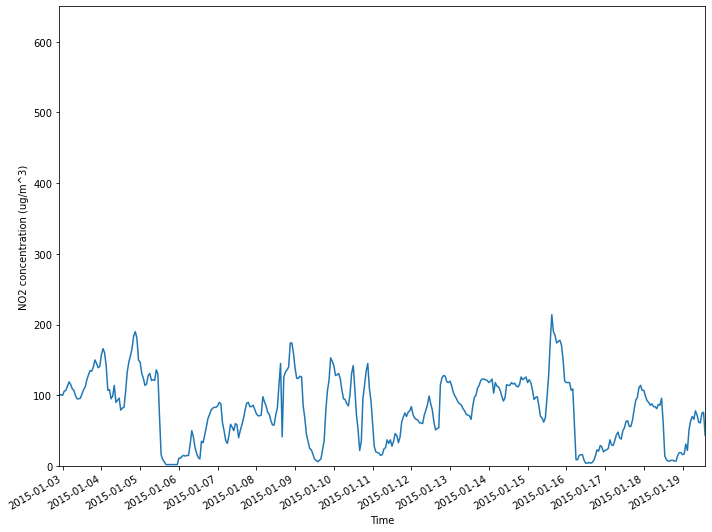

In [7]:
fig, ax = plt.subplots()

ax.plot(df['NO2'])
ax.set_xlabel('Time')
ax.set_ylabel('NO2 concentration (ug/m^3)')

plt.xticks(np.arange(2, 400, 24), ['2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10', '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18', '2015-01-19'])
plt.ylim(0, 650)
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

## Exploration 

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
No,18914.0,25607.500000,5460.145831,16151.0,20879.250,25607.5,30335.75,35064.0
PM2.5,18914.0,79.407220,83.816615,3.0,19.000,54.0,107.00,898.0
PM10,18914.0,103.687485,95.725767,3.0,33.225,78.0,143.00,984.0
SO2,18914.0,13.201725,17.090182,2.0,2.000,7.0,16.00,341.0
NO2,18914.0,55.560272,37.834273,2.0,26.000,47.0,77.00,290.0
CO,18914.0,1324.737573,1351.213878,100.0,500.000,900.0,1600.00,10000.0
O3,18914.0,61.602319,58.980450,2.0,13.000,49.0,87.00,423.0
TEMP,18914.0,12.741331,11.751367,-16.8,2.000,13.0,23.10,38.8
PRES,18914.0,1013.480721,10.470266,987.5,1004.900,1013.2,1022.10,1042.0
DEWP,18914.0,1.399363,13.830859,-35.3,-10.100,1.3,14.00,27.3


In [9]:
cols_to_drop = ['RAIN', 'wd', 'No', 'station']

df = df.drop(cols_to_drop, axis=1)

df.shape

(18914, 11)

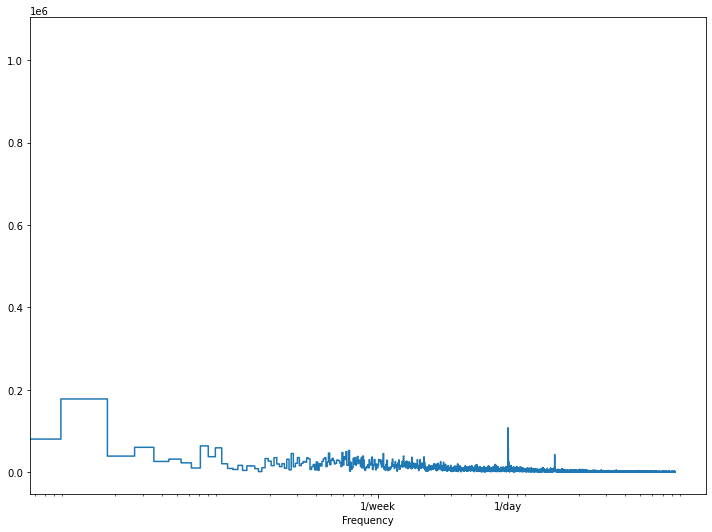

In [10]:
timestamp_s = pd.to_datetime(df.datetime).map(datetime.datetime.timestamp)

fft = tf.signal.rfft(df['NO2'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['NO2'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [11]:
day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [12]:
df = df.drop(['datetime'], axis=1)

df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,day_sin,day_cos
0,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.7,0.707107,7.071068e-01
1,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.7,0.866025,5.000000e-01
2,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.4,0.965926,2.588190e-01
3,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.4,1.000000,7.285825e-12
4,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,1.1,0.965926,-2.588190e-01


## Split data 

In [14]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((13239, 12), (3783, 12), (1892, 12))

## Scale data 

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [16]:
train_df.to_csv('../data/ex_train.csv', header=True, index=False)
val_df.to_csv('../data/ex_val.csv', header=True, index=False)
test_df.to_csv('../data/ex_test.csv', header=True, index=False)